# Circuit Level Choropleth
This notebook creates a choropleth where the regions are the 13 appellate courts in the US Court of Appeals.

To construct the court boundaries, a GeoJSON file with the boundaries for all 94 district courts is used as a basis.



Goal: A customized shapefile with all the circuit courts as shown in the image below.  
![Wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/d/df/US_Court_of_Appeals_and_District_Court_map.svg/620px-US_Court_of_Appeals_and_District_Court_map.svg.png)

* *See [United States Courts website](https://www.uscourts.gov/about-federal-courts/federal-courts-public/court-website-links)*

https://medium.com/tech-carnot/interactive-map-based-visualization-using-plotly-44e8ad419b97


## Installs and Imports

In [1]:
!pip install geopandas
!pip install -U plotly==4.5.0
!pip install geojson

Requirement already up-to-date: plotly==4.5.0 in /usr/local/lib/python3.7/dist-packages (4.5.0)


In [2]:
# Plotly Choropleths require either version > 4.5 or version 4.14.3
import plotly
assert plotly.__version__ in ['4.14.3', '4.5.0']


In [3]:
import json

import geojson
import geopandas as gpd
import pandas as pd
import plotly.express as px
import shapely.geometry

# Shapefiles and GeoJSON

A standard way to create choropleths is using shapefiles. Shapefiles are used to define boundaries of regions so that the area inside of the region can be mapped to a variable. For instance, we can map the percentage of approved cases for a specific region to an area inside the boundaries of that region and assign the area a color.

An alternative to shapefiles is GeoJSON, which is JSON with a very particular schema. That schema specifies that each region be a `Feature` with `geometry` and `properties`. The `geometry` describes the boundaries when the type is `Polygon`, while `properties` stores information about the region. Packing all the regions into one GeoJSON is called a **FeatureCollection**.

Example from [Wikipedia](https://en.wikipedia.org/wiki/GeoJSON#Example)
```
{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "geometry": {
        "type": "Point",
        "coordinates": [102.0, 0.5]
      },
      "properties": {
        "prop0": "value0"
      }
    },
    {
      "type": "Feature",
      "geometry": {
        "type": "LineString",
        "coordinates": [
          [102.0, 0.0], [103.0, 1.0], [104.0, 0.0], [105.0, 1.0]
        ]
      },
      "properties": {
        "prop0": "value0",
        "prop1": 0.0
      }
    },
    {
      "type": "Feature",
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [100.0, 0.0], [101.0, 0.0], [101.0, 1.0],
            [100.0, 1.0], [100.0, 0.0]
          ]
        ]
      },
      "properties": {
        "prop0": "value0",
        "prop1": { "this": "that" }
      }
    }
  ]
}
```

Some helpful links  
- [United States District Court Boundary Shapefiles (1900-2000)](https://www.openicpsr.org/openicpsr/project/100069/version/V1/view)  
- [Federal District Courts - Government GeoInquiries™](https://www.arcgis.com/home/webmap/viewer.html?webmap=98d4c38b558c464f8fff604fae89d2b0)  



### Download Data
- Download US District Court Jurisdictions GeoJSON from here: https://hifld-geoplatform.opendata.arcgis.com/datasets/geoplatform::us-district-court-jurisdictions/about

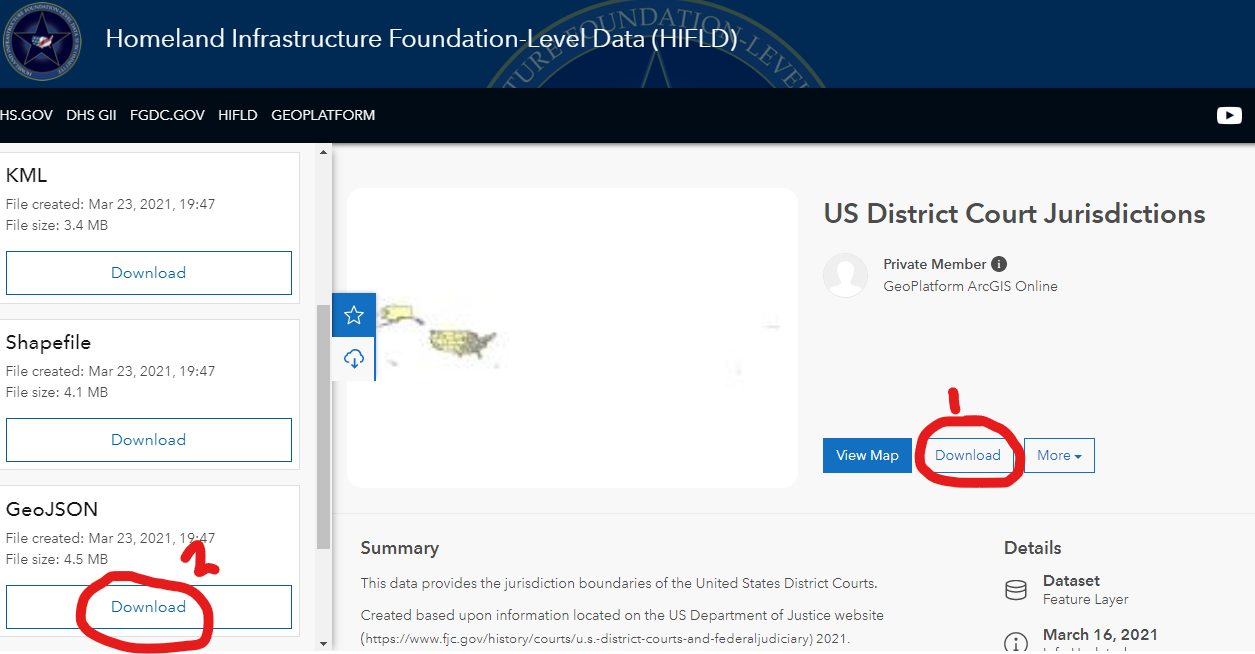

In [4]:
# Load geojson object
with open('US_District_Court_Jurisdictions.geojson') as f:
    Court_districts = json.load(f)

In [5]:
# Which circuits are there?
circuit_names = []
for district in Court_districts['features']:
    circuit_names.append(district['properties']['DISTRICT_N'])
circuit_names = set(circuit_names)
circuit_names

{'1', '10', '11', '2', '3', '4', '5', '6', '7', '8', '9', 'DC'}

### Filtering GeoJSON by DISTRICT_N

Idea: https://gis.stackexchange.com/questions/142802/how-to-delete-a-feature-from-a-geojson-with-python

In [6]:
# Inspect the structure of the GeoJSON dictionary
Court_districts.keys()

dict_keys(['type', 'name', 'crs', 'features'])

In [7]:
Court_districts['type']

'FeatureCollection'

In [8]:
Court_districts['name']

'US_District_Court_Jurisdictions'

In [9]:
Court_districts['crs']

{'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}, 'type': 'name'}

In [10]:
# Test filtering of a single circuit
temp_json = Court_districts.copy()
circuit_nominal = '1' # The circuit number/name (DISTRICT_N)
temp_json['features'] = [district for district in Court_districts['features'] if district['properties']['DISTRICT_N'] == circuit_nominal]
assert len(temp_json['features']) > 0, f"No districts named {circuit_nominal}"

In [11]:
temp_json['features'][0]['properties']

{'ABBR': 'ME',
 'ALAND': 79887426037.0,
 'AWATER': 11746549764.0,
 'CHIEF_JUDG': 'Jon Levy',
 'DISTRICT_N': '1',
 'FID': 30,
 'NAME': 'District of Maine',
 'NOMINATING': 'Barack Obama (D)',
 'SHAPE_Area': 9.75321042297,
 'SHAPE_Length': 37.60348566815044,
 'STATE': 'Maine',
 'STATEFP': '23',
 'Shape_Leng': 37.6034856682,
 'TERM_AS_CH': 2019}

In [12]:
# Check that structure is preserved
temp_json.keys()

dict_keys(['type', 'name', 'crs', 'features'])

### `get_circuit_geojson` function

In [13]:
# Function to create geojson region 
def get_circuit_geojson(all_districts, circuit_nominal):
    temp_json = all_districts.copy()
    temp_json['features'] = [district for district in all_districts['features'] if district['properties']['DISTRICT_N'] == circuit_nominal]
    return temp_json

### Merging two geojson polygons
https://stackoverflow.com/questions/34325030/merging-two-geojson-polygons-in-python  
Proof of concept for joining polygons together to create one contiguous region

In [14]:
# reading in geojson objects, in a GCS (WGS84)
district_1 = get_circuit_geojson(Court_districts, '1')

# pulling out the polygons
poly1 = shapely.geometry.asShape(district_1['features'][0]['geometry'])
poly2 = shapely.geometry.asShape(district_1['features'][1]['geometry'])

# checking to make sure they registered as polygons
print(poly1.geom_type)
print(poly2.geom_type)

# merging the polygons - they are feature collections, containing a point, a polyline, and a polygon - I extract the polygon
# for my purposes, they overlap, so merging produces a single polygon rather than a list of polygons
mergedPolygon = poly1.union(poly2)

# using geojson module to convert from WKT back into GeoJSON format
geojson_out = geojson.Feature(geometry=mergedPolygon, properties={'DISTRICT_N': 1})

MultiPolygon
MultiPolygon


### Merging multiple districts within a circuit to create a new polygon

In [15]:
def merge_geojson(circuit):
    
    # pulling out the polygons
    polygons = []
    for district in circuit['features']:
        poly = shapely.geometry.asShape(district['geometry'])
        polygons.append(poly)
    
    # merging the polygons - they are feature collections, containing a point, a polyline, and a polygon
    mergedPolygon = polygons.pop()
    while polygons:
        try: # catching 
            mergedPolygon = mergedPolygon.union(polygons.pop())
        except:
            print(f"Error with circuit: {district['properties']['DISTRICT_N']}")
    
    # using geojson module to convert from WKT back into GeoJSON format
    geojson_out = geojson.Feature(
        geometry=mergedPolygon, 
        properties={'DISTRICT_N': district['properties']['DISTRICT_N']},
        )

    return geojson_out

### Create GeoJSON dictionary using customized polygons


In [16]:
circuits_geojson = {
    'type': 'FeatureCollection',
    'name': 'US_Circuit_Court_Jurisdictions',
    'crs': {'properties': {
        'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}, # Need to verify this spec
        'type': 'name'
        },
    'features': []
    }

# List of circuits as geojson features
for circuit_name in circuit_names:
    circuits_geojson['features'].append(merge_geojson(get_circuit_geojson(Court_districts, circuit_name)))

# TODO: Handle TopologyException errors

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -84.29866913799998 32.999677276000057 at -84.29866913799998 32.999677276000057


Error with circuit: 11


In [17]:
circuits_geojson['features'][2]['properties']

{'DISTRICT_N': 'DC'}

### Test Data

To test the plot, create a dataframe with mock data. The first column is the circuit name or the `DISTRICT_N` property of the region. The second column, which is mapped to color, is a randomly generated approval ratio.

In [18]:
import random
data = {
    'DISTRICT_N': list(circuit_names),
    'Approval': [random.random() for _ in range(len(circuit_names))]
}
df = pd.DataFrame(data=data)

In [19]:
df.head()

DISTRICT_N  Approval
0          1  0.733993
1          6  0.690887
2         DC  0.345804
3          8  0.609947
4          2  0.987534

### Plotly Express
Thanks to Yash Sanghvi's [post on Tech@Carnot](https://medium.com/tech-carnot/interactive-map-based-visualization-using-plotly-44e8ad419b97), the following code was crafted to create the choropleth.


In [20]:
fig = px.choropleth(
    data_frame=df,
    geojson=circuits_geojson,   # the GeoJSON dictionary containing shapes
    locations='DISTRICT_N',     # the column with circuit numbers
    color='Approval',           # map color to approval rate
    color_continuous_scale='Viridis',
    range_color=(0,1),          # range of mapped values
    featureidkey='properties.DISTRICT_N', # maps locations to shape property
    projection='mercator',      # Alaska is too large w/ mercator
)

fig.update_geos(
    fitbounds='locations',      # which parts of the earth to show
    visible=True,
    showlakes=True
    ) 
fig.update_layout(margin={'r':1, "t":1, "l":1, "b":1})
fig.show()

# Improvements and Bugfixes
While this proof-of-concept appears successful, there are several aspects and areas of this process that can be improved.

- Fix missing regions in circuits 10 and 11 apparently due to errors when merging polygons with `shapely`.
- Add properties to final GeoJSON so more information appears on hover
- Label regions according to circuit
- Rename DISTRICT_N to accurately reflect that it is a circuit
- Alaska is too big, explore different projections or repositioning techniques
- Filter out or group territories (e.g. Guam, US Virgin Islands)
- Adjust layout so contiguous US states are in the viewing window by default
- Adjust figure size
- Add a title and description to the plot
- Fix: `showlakes` has no effect on the regions plotted.


# Exporting Plotly Choropleth as JSON

In [21]:
with open("Circuit_choropleth_plotly.json", "w") as f:
    json.dump(fig.to_json(), f)

# Implementation in the HRF Asylum web application
In order to implement this in the DS API, we need to gather some test data from the back-end and perform some aggregate stats (counts, averages, ...)

There are two ways to implement this in the web application:
1. Coordinate with web back-end team to set up an endpoint in the DS API that can accept POST requests. Create the choropleth using Plotly Express in Python. Return the plot as JSON format via `fig.to_json()`.
2. Give the web back-end team the customized GeoJSON file and assist them in calculating the aggregate statistics and creating a choropleth using Plotly in Javascript.

## JSON Case Data
The back-end sends the DS API JSON data with case information via a POST request. This is an example of the data that is sent.

*As of 5/26/2021. The format and fields may change in the future. Be sure to update this example when that happens.*

In [22]:
jsonstring = """
{
    "data": [
        {
            "judge_id": 2,
            "first_name": "Patricia",
            "last_name": "Cole",
            "judge_county": "Virginia Falls",
            "appointed_by": "Janet Reno",
            "case_id": "099f113a-3514-45be-a2c7-9257eded3fe7",
            "case_url": "https://hrf-asylum-cases.s3.amazonaws.com/2ff54195-ce30-456c-be63-2a6c765bdce2.pdf",
            "case_number": "A079-531-484",
            "case_date": "2012-08-30T00:00:00.000Z",
            "case_outcome": "Granted",
            "country_of_origin": "El Salvador",
            "protected_grounds": "Political Opinion",
            "application_type": "initial",
            "case_origin_city": "Los Angeles",
            "case_origin_state": "CA",
            "gender": "Female",
            "appellate": false,
            "status": "approved"
        },
        {
            "judge_id": 2,
            "first_name": "Patricia",
            "last_name": "Cole",
            "judge_county": "Virginia Falls",
            "appointed_by": "Janet Reno",
            "case_id": "75a1fb1b-1ffe-45d6-b347-9ef67d4b9180",
            "case_url": "https://hrf-asylum-cases.s3.amazonaws.com/2ff54195-ce30-456c-be63-2a6c765bdce2.pdf",
            "case_number": "A089-207-04",
            "case_date": "2012-01-31T00:00:00.000Z",
            "case_outcome": "Sustained",
            "country_of_origin": "Honduras",
            "protected_grounds": "Nationality",
            "application_type": "initial",
            "case_origin_city": "Imperial",
            "case_origin_state": "CA",
            "gender": "Female",
            "appellate": false,
            "status": "approved"
        },
        {
            "judge_id": 2,
            "first_name": "Patricia",
            "last_name": "Cole",
            "judge_county": "Virginia Falls",
            "appointed_by": "Janet Reno",
            "case_id": "04fbe436-da2c-4e20-9cfb-2221ad8e1f29",
            "case_url": "https://hrf-asylum-cases.s3.amazonaws.com/2ff54195-ce30-456c-be63-2a6c765bdce2.pdf",
            "case_number": "A044-857-956",
            "case_date": "2011-12-15T00:00:00.000Z",
            "case_outcome": "Terminated",
            "country_of_origin": "Mexico",
            "protected_grounds": "Political Opinion",
            "application_type": "initial",
            "case_origin_city": "San Antonio",
            "case_origin_state": "TX",
            "gender": "Female",
            "appellate": false,
            "status": "approved"
        }
    ]
}
"""